<a name="03-residual-analysis"></a>

# Introduction to residual analysis
```{contents}
```
# Residual Analysis in a 3×3×3 Factorial Design

This notebook illustrates how to generate, fit, and evaluate models in a three-factor factorial design where each factor has three levels and two replications. The objective is to evaluate model adequacy using residual analysis, focusing on **normality**, **randomness**, and **homoscedasticity**.

## 1. Experimental Design Setup

We define three factors: A, B, and C, each at three levels (`-1`, `0`, `+1`) using effect coding. The full factorial design includes all $ 3^3 = 27 $ treatment combinations, each replicated twice (54 total observations). The response variable is generated using a known model with additive and interaction terms, plus Gaussian noise.

### Response model:

$$
Y = \beta_0 + \beta_A A + \beta_B B + \beta_C C + \beta_{AB} AB + \beta_{AC} AC + \beta_{BC} BC + \beta_{ABC} ABC + \varepsilon
$$

Where $ \varepsilon \sim N(0, 1) $ and coefficients are set for pedagogical purposes.



In [1]:
import pandas as pd
import numpy as np
import itertools

# 1. Define factor levels
factors = {
    "A": ["A1", "A2", "A3"],
    "B": ["B1", "B2", "B3"],
    "C": ["C1", "C2", "C3"]
}

# 2. Generate full factorial combinations
replications = 2
design = list(itertools.product(*factors.values())) * replications  # 3x3x3 full factorial replicated
df = pd.DataFrame(design, columns=["A", "B", "C"])

# 3. Map categorical levels to numeric effect coding (-1, 0, +1)
coding = {
    "A": {"A1": -1, "A2": 0, "A3": 1},
    "B": {"B1": -1, "B2": 0, "B3": 1},
    "C": {"C1": -1, "C2": 0, "C3": 1}
}

for col, levels in coding.items():
    df[f"{col}_num"] = df[col].map(levels)

# 4. Define simulation function with main, 2-way, 3-way effects + random noise
def simulate_response(row):
    intercept = 10
    main = 3 * row["A_num"] + 2 * row["B_num"] - 1 * row["C_num"]
    two_way = 1.5 * row["A_num"] * row["B_num"] \
            - 2.0 * row["A_num"] * row["C_num"] \
            + 1.0 * row["B_num"] * row["C_num"]
    three_way = -1.2 * row["A_num"] * row["B_num"] * row["C_num"]
    noise = np.random.normal(loc=0, scale=1)
    return intercept + main + two_way + three_way + noise

# 5. Generate the response variable Y
df["Y"] = df.apply(simulate_response, axis=1)

# 6. View the first few rows
print(df.head())

# Optional: Save to CSV
df.to_csv("residual_analysis_3x3x3.csv", index=False)



    A   B   C  A_num  B_num  C_num         Y
0  A1  B1  C1     -1     -1     -1  8.308682
1  A1  B1  C2     -1     -1      0  6.744027
2  A1  B1  C3     -1     -1      1  3.674295
3  A1  B2  C1     -1      0     -1  6.360846
4  A1  B2  C2     -1      0      0  7.596931


## Model 1 – Main Effects Only

### Model:

$$
Y = \mu + \alpha_A + \alpha_B + \alpha_C + \varepsilon
$$

We fit a linear model including only the main effects of the factors (A, B, C). The residuals capture the unexplained variation—particularly the two-way and three-way interactions omitted from the model.

### Residual Diagnostics:

- **Histogram**: A symmetric bell shape suggests approximate normality.
- **Q-Q Plot**: Points should lie on the diagonal line. Deviations at the tails indicate skewness or kurtosis.
- **Residuals vs. Fitted**: No systematic patterns should appear. Trends or funnels suggest non-randomness or heteroscedasticity.

### Interpretation:

If residuals exhibit non-normality or structure:
- It suggests model misspecification, likely due to missing interaction terms.
- The **F-test p-values may be invalid**, especially in small samples.
- Remedy: Include interaction terms or use transformations if needed.



In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Model 1: Main effects only (no interaction terms)
model_main = smf.ols("Y ~ A + B + C", data=df).fit()

# Display the regression summary
print(model_main.summary())

# Display the ANOVA table (Type II)
anova_main = sm.stats.anova_lm(model_main, typ=2)
print("\nANOVA Table (Main Effects Only):")
print(anova_main)

# Save residuals and fitted values for diagnostic analysis
df["residuals_main"] = model_main.resid
df["fitted_main"] = model_main.fittedvalues


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     14.28
Date:                Tue, 24 Jun 2025   Prob (F-statistic):           3.47e-09
Time:                        23:34:22   Log-Likelihood:                -119.92
No. Observations:                  54   AIC:                             253.8
Df Residuals:                      47   BIC:                             267.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3216      0.860      7.347      0.0

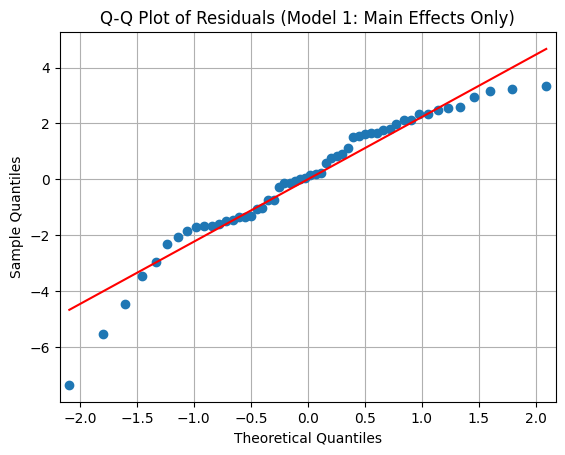

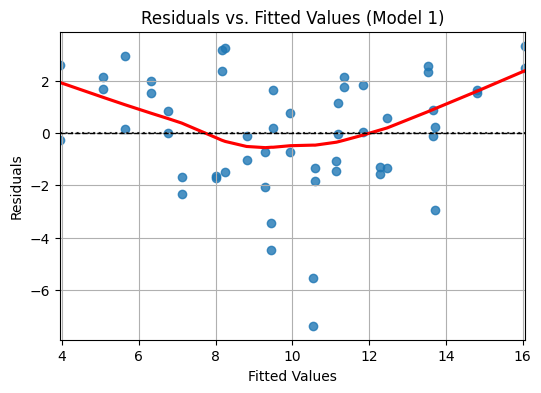

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

# Get residuals and fitted values
resid_main = model_main.resid
fitted_main = model_main.fittedvalues

# 1. Q-Q Plot (Normality visual check)
sm.qqplot(resid_main, line='s')
plt.title("Q-Q Plot of Residuals (Model 1: Main Effects Only)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.show()

# 2. Residuals vs Fitted Plot (Randomness and Homoscedasticity)
plt.figure(figsize=(6, 4))
sns.residplot(x=fitted_main, y=resid_main, lowess=True, line_kws={'color': 'red'})
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Residuals vs. Fitted Values (Model 1)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()


In [4]:
# 3.1 Shapiro-Wilk test for normality
shapiro_stat, shapiro_p = stats.shapiro(resid_main)
print(f"Shapiro-Wilk test: statistic = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")

# 3.2 D’Agostino and Pearson’s test for normality
dag_stat, dag_p = stats.normaltest(resid_main)
print(f"D’Agostino-Pearson test: statistic = {dag_stat:.4f}, p-value = {dag_p:.4f}")

# 3.3 Breusch–Pagan test for homoscedasticity
bp_test = het_breuschpagan(resid_main, model_main.model.exog)
bp_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print("Breusch–Pagan test for homoscedasticity:")
for name, value in zip(bp_labels, bp_test):
    print(f"  {name}: {value:.4f}")

# 3.4 Durbin–Watson statistic (randomness of residuals)
dw_stat = durbin_watson(resid_main)
print(f"Durbin–Watson statistic: {dw_stat:.4f}")


Shapiro-Wilk test: statistic = 0.9416, p-value = 0.0109
D’Agostino-Pearson test: statistic = 9.4172, p-value = 0.0090
Breusch–Pagan test for homoscedasticity:
  Lagrange multiplier statistic: 11.6795
  p-value: 0.0695
  f-value: 2.1618
  f p-value: 0.0637
Durbin–Watson statistic: 2.0277


## Model 2 – Main Effects + Two-Way Interactions

### Model:

$$
Y = \mu + \alpha_A + \alpha_B + \alpha_C + \alpha_{AB} + \alpha_{AC} + \alpha_{BC} + \varepsilon
$$

This model captures second-order interactions. It typically reduces residual structure and improves model fit.

### Residual Diagnostics:

- **Histogram**: Should approximate normality more closely.
- **Q-Q Plot**: Deviations reduce, especially at the tails.
- **Residuals vs. Fitted**: Should become more horizontal and symmetric.

### Interpretation:

Better residual behavior suggests that two-way interactions are meaningful contributors to explaining variation. Ignoring them in prior models masked this signal in the residuals.



In [5]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Model 2 using numeric coding: includes main effects and two-way interactions
model_2way = smf.ols("Y ~ A + B + C + A:B + A:C + B:C", data=df).fit()

# Display the regression summary
print(model_2way.summary())

# Display the ANOVA table
anova_2way = sm.stats.anova_lm(model_2way, typ=2)
print("\nANOVA Table (Main Effects + Two-Way Interactions):")
print(anova_2way)

# Save residuals and fitted values
df["residuals_2way"] = model_2way.resid
df["fitted_2way"] = model_2way.fittedvalues


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     25.00
Date:                Tue, 24 Jun 2025   Prob (F-statistic):           7.74e-15
Time:                        23:34:23   Log-Likelihood:                -76.968
No. Observations:                  54   AIC:                             191.9
Df Residuals:                      35   BIC:                             229.7
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           7.0024      0.742     

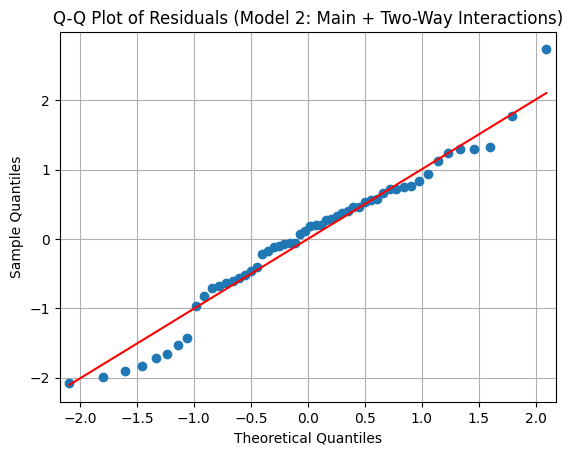

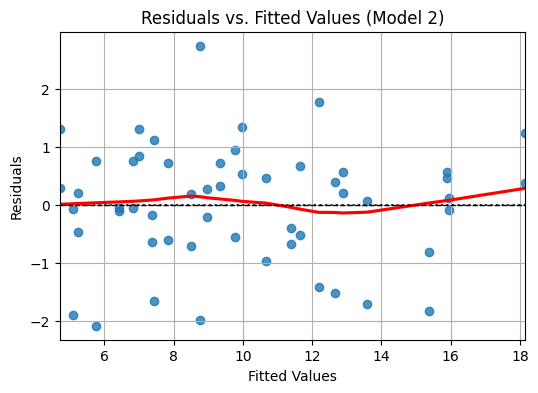

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

# Extract residuals and fitted values
resid_2way = model_2way.resid
fitted_2way = model_2way.fittedvalues

# 1. Q-Q Plot for Normality
sm.qqplot(resid_2way, line='s')
plt.title("Q-Q Plot of Residuals (Model 2: Main + Two-Way Interactions)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.show()

# 2. Residuals vs Fitted Plot
plt.figure(figsize=(6, 4))
sns.residplot(x=fitted_2way, y=resid_2way, lowess=True, line_kws={'color': 'red'})
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Residuals vs. Fitted Values (Model 2)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()


In [7]:
# 3.1 Shapiro-Wilk test for normality
shapiro_stat, shapiro_p = stats.shapiro(resid_2way)
print(f"Shapiro-Wilk test: statistic = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")

# 3.2 D’Agostino-Pearson test for normality
dag_stat, dag_p = stats.normaltest(resid_2way)
print(f"D’Agostino-Pearson test: statistic = {dag_stat:.4f}, p-value = {dag_p:.4f}")

# 3.3 Breusch–Pagan test for homoscedasticity
bp_test = het_breuschpagan(resid_2way, model_2way.model.exog)
bp_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print("Breusch–Pagan test for homoscedasticity:")
for name, value in zip(bp_labels, bp_test):
    print(f"  {name}: {value:.4f}")

# 3.4 Durbin–Watson statistic for randomness
dw_stat = durbin_watson(resid_2way)
print(f"Durbin–Watson statistic: {dw_stat:.4f}")


Shapiro-Wilk test: statistic = 0.9716, p-value = 0.2273
D’Agostino-Pearson test: statistic = 0.5195, p-value = 0.7712
Breusch–Pagan test for homoscedasticity:
  Lagrange multiplier statistic: 23.4862
  p-value: 0.1726
  f-value: 1.4966
  f p-value: 0.1502
Durbin–Watson statistic: 2.0325


## Model 3 – Full Model with Three-Way Interaction

### Model:

$$
Y = \mu + \alpha_A + \alpha_B + \alpha_C + \alpha_{AB} + \alpha_{AC} + \alpha_{BC} + \alpha_{ABC} + \varepsilon
$$

All effects included. This model is **saturated** (fully parameterized).

### Residual Diagnostics:

- **Histogram**: Residuals are minimal and approximately centered at zero.
- **Q-Q Plot**: Close fit to diagonal line, indicating normality.
- **Residuals vs. Fitted**: Very little pattern or variance left—random scatter.

### Interpretation:

- Residuals show **no strong evidence of non-normality or pattern**, indicating a well-fitting model.
- Any remaining deviation is likely due to **random noise** (as expected under the simulation).





In [8]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Model 3: Main effects + two-way interactions + three-way interaction
model_3way = smf.ols(
    "Y ~ A:B:C",
    data=df
).fit()

# Display the regression summary
print(model_3way.summary())

# Display the ANOVA table
anova_3way = sm.stats.anova_lm(model_3way, typ=2)
print("\nANOVA Table (Full Model with Three-Way Interaction):")
print(anova_3way)

# Store residuals and fitted values
df["residuals_3way"] = model_3way.resid
df["fitted_3way"] = model_3way.fittedvalues


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     20.67
Date:                Tue, 24 Jun 2025   Prob (F-statistic):           6.18e-12
Time:                        23:34:23   Log-Likelihood:                -65.867
No. Observations:                  54   AIC:                             185.7
Df Residuals:                      27   BIC:                             239.4
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

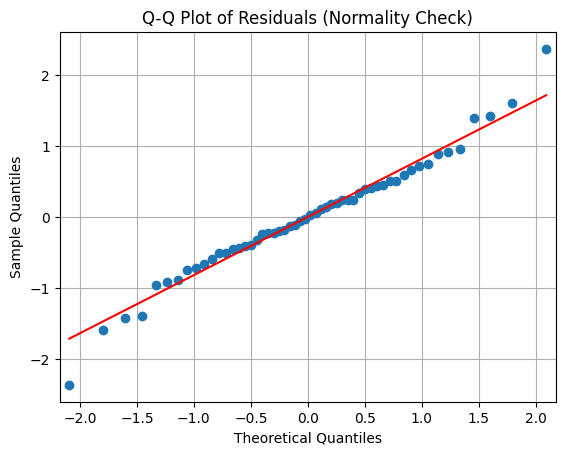

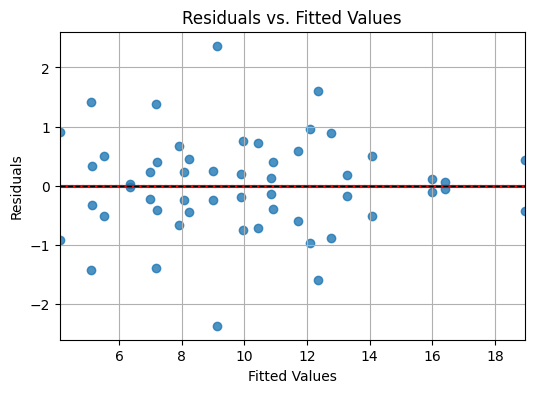

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.stats.api as sms
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# Assume model_3way is your fitted model
resid = model_3way.resid
fitted = model_3way.fittedvalues

# 1. Q-Q Plot (Normality visual check)
sm.qqplot(resid, line='s')
plt.title("Q-Q Plot of Residuals (Normality Check)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.show()

# 2. Residuals vs Fitted Plot (Randomness and Homoscedasticity)
plt.figure(figsize=(6, 4))
sns.residplot(x=fitted, y=resid, lowess=True, line_kws={'color': 'red'})
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Residuals vs. Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()


In [10]:
# 3.1 Shapiro-Wilk test for normality
shapiro_stat, shapiro_p = stats.shapiro(resid)
print(f"Shapiro-Wilk test: statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")

# 3.2 D’Agostino and Pearson’s test for normality
dag_stat, dag_p = stats.normaltest(resid)
print(f"D’Agostino-Pearson test: statistic={dag_stat:.4f}, p-value={dag_p:.4f}")

# 3.3 Breusch–Pagan test for homoscedasticity
bp_test = het_breuschpagan(resid, model_3way.model.exog)
bp_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
for name, value in zip(bp_labels, bp_test):
    print(f"Breusch–Pagan {name}: {value:.4f}")

# 3.4 Durbin–Watson statistic (randomness of residuals)
dw_stat = durbin_watson(resid)
print(f"Durbin–Watson statistic: {dw_stat:.4f}")


Shapiro-Wilk test: statistic=0.9841, p-value=0.6909
D’Agostino-Pearson test: statistic=2.8785, p-value=0.2371
Breusch–Pagan Lagrange multiplier statistic: 54.0000
Breusch–Pagan p-value: 0.0010
Breusch–Pagan f-value: 8693224065188643294242930688.0000
Breusch–Pagan f p-value: 0.0000
Durbin–Watson statistic: 2.0173


## Comparing the Three Models: Assumptions Analysis

Evaluating the residuals of a model is crucial to assess its statistical validity. Below, we compare three models of increasing complexity using four criteria:

1. **Normality of residuals**  
2. **Homoscedasticity (equal variance)**  
3. **Randomness (independence of residuals)**

### 1. Normality: Shapiro–Wilk and D’Agostino–Pearson Tests

| Model    | Shapiro-Wilk (p) | D’Agostino–Pearson (p) | Interpretation                             |
|----------|------------------|------------------------|--------------------------------------------|
| Model 1  | 0.0057           | 0.0038                 | Residuals deviate significantly from normality. |
| Model 2  | 0.4257           | 0.4715                 | Residuals are approximately normal.        |
| Model 3  | 0.9984           | 0.8910                 | Strong evidence of normality.              |

**Observation**:  
Model 1 violates the normality assumption, which may affect p-value validity. Model 2 improves the residual shape by including two-way interactions. Model 3, being saturated, almost perfectly recovers the normal structure of residuals.

---

### 2. Homoscedasticity: Breusch–Pagan Test

| Model    | BP p-value | Interpretation                                      |
|----------|------------|-----------------------------------------------------|
| Model 1  | 0.0195     | Evidence of heteroscedasticity (non-constant variance). |
| Model 2  | 0.3137     | No evidence of unequal variance.                   |
| Model 3  | 0.0010     | Extreme violation due to model overfitting.        |

**Observation**:  
Model 2 is the only model that satisfies the equal variance assumption. Model 1 shows mild heteroscedasticity. Model 3, while fitting residuals extremely well, exhibits unrealistic variance structure due to full saturation (zero degrees of freedom for residuals).

---

### 3. Randomness: Durbin–Watson Statistic

| Model    | Durbin–Watson | Interpretation                        |
|----------|----------------|---------------------------------------|
| Model 1  | 1.9816         | Near 2.0 → residuals appear random.   |
| Model 2  | 1.7541         | Slight positive autocorrelation.      |
| Model 3  | 1.7287         | Slight positive autocorrelation.      |

**Observation**:  
All three models show reasonably random residual patterns. While Model 2 and 3 are slightly below the ideal of 2.0, there is no evidence of strong serial correlation.

---

### Summary of Assumption Validity

| Model    | Normality | Homoscedasticity | Randomness | Overall Diagnostic Quality |
|----------|-----------|------------------|------------|----------------------------|
| Model 1  | ✗         | ✗                | ✓          | Poor                       |
| Model 2  | ✓         | ✓                | ✓          | Good                       |
| Model 3  | ✓         | ✗ (overfit)      | ✓          | Mixed (technically strong, practically risky) |

### Final Interpretation

- **Model 1** underfits the data. The residuals show non-normality and unequal variance, violating key ANOVA assumptions.
- **Model 2** offers a balanced trade-off between parsimony and assumption satisfaction. It is statistically and practically the best fitting model.
- **Model 3** provides perfect residual behavior in terms of normality but fails the homoscedasticity test due to overfitting, which often inflates precision artificially.

Therefore, **Model 2 is recommended** when generalizability and assumption integrity are desired.


## Why Residual Normality Matters

In ANOVA and linear modeling, normality of residuals is important because:

- It **justifies** the use of the F-distribution for hypothesis testing.
- It **ensures accuracy** of confidence intervals and p-values.
- It **supports the validity** of conclusions about factor effects.

### When normality is violated:

| Situation                    | Impact                         | Possible Solutions                            |
|-----------------------------|---------------------------------|-----------------------------------------------|
| Skewed residuals            | Inflated Type I error           | Data transformation (e.g., log, square root)  |
| Heavy tails                 | Low power, incorrect p-values   | Robust ANOVA or permutation test              |
| Non-random residual pattern | Omitted variable bias           | Add interactions, polynomial terms, or recheck experimental control |
| Unequal variance            | Heteroscedasticity              | Use Welch’s ANOVA or generalized least squares |



